In [1]:
import sys
sys.path.append("../")

from collections import OrderedDict

import kornia as korn
import numpy as np
from PIL import Image

import torch
import torchvision.transforms as T
from torchvision.utils import make_grid

from ul.nets import WMEncoder
from ul.data_loading import get_atari

In [2]:
def th2pil(t):
    t = t.squeeze().permute(1, 2, 0) * 255
    return Image.fromarray(t.numpy().astype(np.uint8))

In [4]:
ckpt = torch.load("../results/2022Sep01-203054_6games/0000_atari--dev/0/model_1500000.pkl")
ckpt = OrderedDict({".".join(k.split(".")[1:]):v for k,v in ckpt["model"].items() if "encoder" in k})

enc = WMEncoder(3, z_ch=8)
enc.load_state_dict(ckpt)

<All keys matched successfully>

In [16]:
dset = iter(get_atari("../data/6games/{0235..0300}.tar"))

In [55]:
x, sample = next(dset)

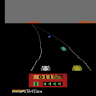

In [56]:
th2pil(x)

In [57]:
z = enc(x.unsqueeze(0)).view((8, 1, 16, 16)).detach()

In [58]:
print(z[:4].min(), z[:4].max())

tensor(-53.9745) tensor(44.8562)


In [46]:
z = enc(x.unsqueeze(0)).view((8, 1, 16, 16)).detach()
zmin, zmax = z.min(), z.max()
z = (z - zmin) / (zmax - zmin)

In [47]:
stuff = torch.cat([
    korn.geometry.rescale(x.unsqueeze(0), (2,2), interpolation='nearest'), 
    korn.geometry.rescale(z.expand(-1, 3, -1, -1), (12,12), interpolation='nearest')
], dim=0)

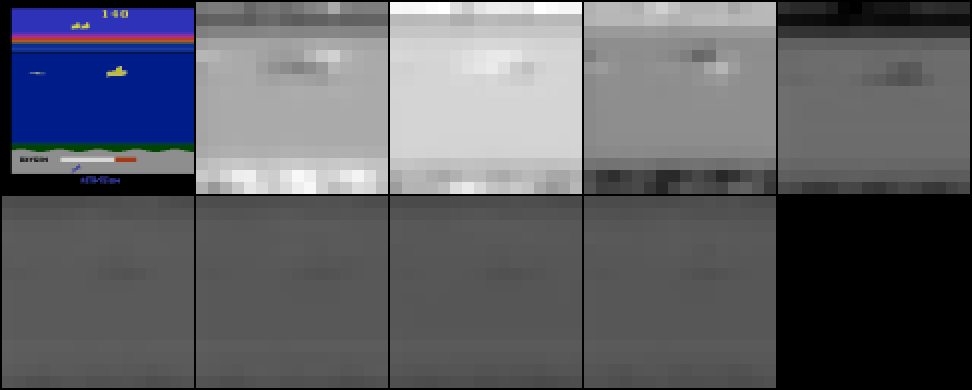

In [48]:
th2pil(make_grid(stuff, normalize=True, nrow=5))

In [212]:
96 / 6

16.0